In [1]:
import sys
sys.path.append("..")
import torch
import torch_geometric as tg

import networkx as nx
import numpy as np

from torch_geometric.data import Data, Batch
from src.model.springmodel import SpringModel
from src.data_generater.spring import SpringSim
from src.utils import sample

import matplotlib.pyplot as plt

from torchdiffeq import odeint

In [2]:
# args
cuda_id = "cpu"
device = torch.device(cuda_id)
pos_in_dim = 2
vel_in_dim = 2
edge_in_dim = 4
hid_dim = 64

In [3]:
prediction_step = 501
n_balls = 30

In [4]:
val_batch = sample(prediction_step, n_balls=n_balls).to(device)

<ipython-input-4-1b5bd61c19b4>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  val_batch = sample(prediction_step, n_balls=n_balls).to(device)


In [5]:
model = SpringModel(pos_in_dim, edge_in_dim, vel_in_dim, hid_dim)
model = model.to(device)
model.load_state_dict(torch.load("../checkpoints/spring_base_model.pt"))
model.edge_index = val_batch.edge_index
model.eval()

node_f = torch.cat((val_batch.pos_0, val_batch.vel_0), dim=1)
node_n = torch.cat((val_batch.pos_res, val_batch.vel_res), dim=2)
pred_node_n = odeint(func=model, y0=node_f, t=val_batch.delta_t, method="rk4")

In [6]:
pos_pred, vel_pred = pred_node_n[:, :, :2], pred_node_n[:, :, -2:]

In [7]:
pos_pred = pos_pred.detach().cpu().numpy()

In [ ]:
pos_true = val_batch.pos_res.cpu().numpy()

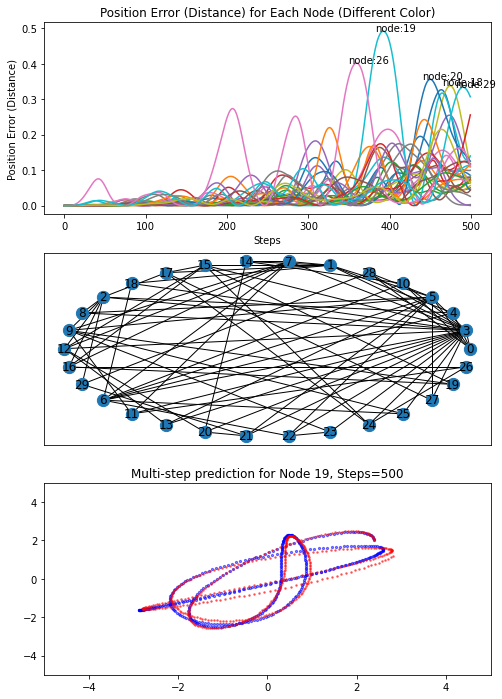

In [29]:
fig, ax = plt.subplots(3, figsize=(8,12))
# 画出每个节点的位置预测误差随时间的变化
distance_error = np.sum((pos_pred[1:] - pos_true)**2, axis=2)
ax[0].plot(distance_error)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Position Error (Distance)")
ax[0].set_title("Position Error (Distance) for Each Node (Different Color)")

maxErrorPerNode = np.max(distance_error, axis=0)
nodeSortByError = np.argsort(maxErrorPerNode)[::-1]
text = {}
for n in nodeSortByError[:5]:
    node_seq = distance_error[:, n]
    step = np.where(node_seq==maxErrorPerNode[n])[0][0]
    ax[0].text(step-10, maxErrorPerNode[n], "node:{}".format(n))

# 画出背后的图
G = nx.Graph()
G.add_edges_from(val_batch.edge_index.T.detach().cpu().numpy())
nx.draw_networkx(G, pos=nx.layout.circular_layout(G), node_size =150, ax=ax[1])

# 画出所有节点的轨迹
for i in nodeSortByError[:1]:
    ax[2].scatter(pos_pred[1:, i, 0], pos_pred[1:, i, 1], s=5, c="b", alpha=0.5)
    ax[2].scatter(pos_true[:, i, 0], pos_true[:, i, 1], s=2.5, c="r", alpha=0.5)
ax[2].set_title("Multi-step prediction for Node {}, Steps={}".format(
    nodeSortByError[:1][0],pos_true.shape[0]))
ax[2].set_xlim([-5,5])
ax[2].set_ylim([-5,5])
#plt.savefig("../figs/prediction_analysis_ode.pdf")
plt.show()